# Data preprocessing of Ranking School Board districts and Census demographic data

In [428]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
import os
import maup

In [429]:
gdf = gpd.read_file('rankin_school_districts_2022.geojson')

<Axes: >

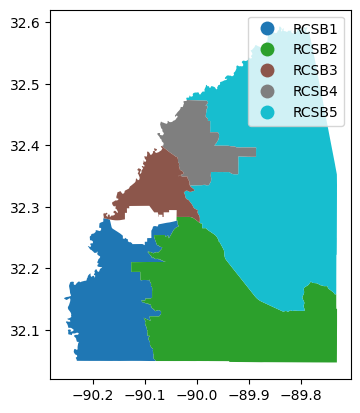

In [430]:
gdf.plot(column='district', legend=True)

### Data downloaded

- Data was queried from here: https://gis.cmpdd.org/server/rest/services/Hosted/Rankin_County_Feature_Layer/FeatureServer/47/query
- and accessed here: https://gis.cmpdd.org/server/rest/services/Hosted/Rankin_County_Feature_Layer/FeatureServer
via GIS Maps / Rankin County, Mississippi (https://www.rankincounty.org/topic/subtopic.php?topicid=18&structureid=14)

help accessing using: https://www.youtube.com/watch?v=LsYgtjkm69Y

Plan adopted May 25, 2022
- https://cmpdd.org/rankin-county-school-board-districts-plan/

***********************

There is a hole in Rankin County School district that is Pearl School District. When creating plans, I don't want to accidently step into Pearl School District

In [431]:
from pygris import counties, block_groups, tracts

ms_tiger = counties(state = "MS", cache=True)
county = ms_tiger[ms_tiger['NAME'] == 'Rankin']

Using the default year of 2021
Using FIPS code '28' for input 'MS'


In [432]:
county.to_crs(gdf.crs, inplace=True)
county.crs == gdf.crs

/Users/kristenakey/.local/share/virtualenvs/rankin_school-board-tzA4L7yf/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


True

<Axes: >

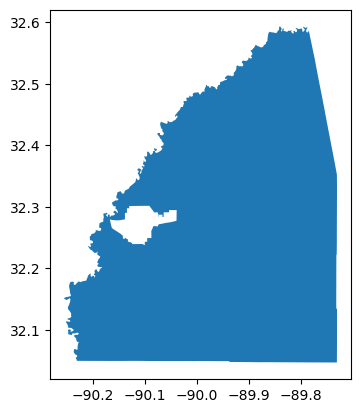

In [433]:
gdf.dissolve().plot()

In [434]:
pearl = county.difference(gdf.dissolve(), align=False)

In [435]:
# pearl.to_file('pearl-school-district.shp')

<Axes: >

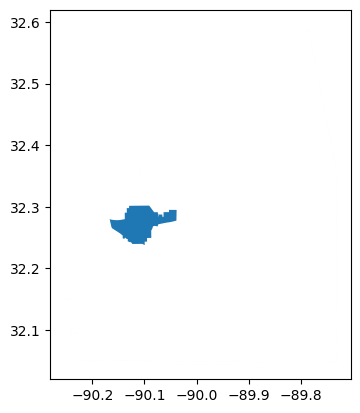

In [436]:
pearl.plot()

***********************

### Subset other geographies down to just Rankin county

In [437]:
blocks_2020 = gpd.read_file('../ms_pl2020_b/ms_pl2020_p1_b.shp')
blocks_2020.to_crs(gdf.crs, inplace=True)
blocks_2020 = blocks_2020[blocks_2020['GEOID20'].str[:5] == '28121']
# blocks_2020.to_file('../ms_pl2020_b/ms_pl2020_p1_b-rankin_county.shp')

In [438]:
vtds_2020 = gpd.read_file('../tl_2020_28_vtd20/tl_2020_28_vtd20.shp')
vtds_2020.to_crs(gdf.crs, inplace=True)
vtds_2020 = vtds_2020[vtds_2020['COUNTYFP20'] == '121']
# vtds_2020.to_file('../tl_2020_28_vtd20/tl_2020_28_vtd20-rankin_county.shp')

<Axes: >

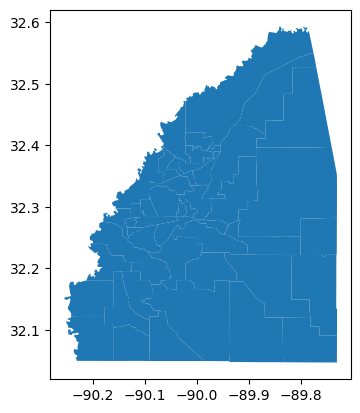

In [439]:
vtds_2020.plot()

### get student data - block-level

In [440]:
vars = [{"B14001_002E": "Total_Enrolled", 
         
        "B01001_001E": "TOTAL", 
        "B01001_003E": "under_5_m", "B01001_027E": "under_5_f",
        "B01001_004E": "5_9_m",  "B01001_028E": "5_9_f",
        "B01001_005E": "10_14_m", "B01001_029E": "10_14_f", 
        "B01001_006E": "15_17_m",  "B01001_030E": "15_17_f"},

        {"B01001A_003E": "under_5_m_white", "B01001A_018E": "under_5_f_white",
        "B01001A_004E": "5_9_m_white", "B01001A_019E": "5_9_f_white",
        "B01001A_005E": "10_14_m_white", "B01001A_020E": "10_14_f_white",        
        "B01001A_006E": "15_17_m_white", "B01001A_021E": "15_17_f_white"},              
        
        {"B01001B_003E": "under_5_m_black", "B01001B_018E": "under_5_f_black",
        "B01001B_004E": "5_9_m_black", "B01001B_019E": "5_9_f_black",                    
        "B01001B_005E": "10_14_m_black", "B01001B_020E": "10_14_f_black",     
        "B01001B_006E": "15_17_m_black", "B01001B_021E": "15_17_f_black"},                              

        {"B01001C_003E": "under_5_m_aian", "B01001C_018E": "under_5_f_aian",
        "B01001C_004E": "5_9_m_aian", "B01001C_019E": "5_9_f_aian",   
        "B01001C_005E": "10_14_m_aian", "B01001C_020E": "10_14_f_aian",        
        "B01001C_006E": "15_17_m_aian", "B01001C_021E": "15_17_f_aian"},    

        {"B01001D_003E": "under_5_m_asian", "B01001D_018E": "under_5_f_asian",
        "B01001D_004E": "5_9_m_asian", "B01001D_019E": "5_9_f_asian",   
        "B01001D_005E": "10_14_m_asian", "B01001D_020E": "10_14_f_asian",   
        "B01001D_006E": "15_17_m_asian", "B01001D_021E": "15_17_f_asian"},      
          
        {"B01001E_003E": "under_5_m_aapi", "B01001E_018E": "under_5_f_aapi",
        "B01001E_004E": "5_9_m_aapi", "B01001E_019E": "5_9_f_aapi",   
        "B01001E_005E": "10_14_m_aapi", "B01001E_020E": "10_14_f_aapi",   
        "B01001E_006E": "15_17_m_aapi", "B01001E_021E": "15_17_f_aapi"}, 

        {"B01001F_003E": "under_5_m_other", "B01001F_018E": "under_5_f_other",
        "B01001F_004E": "5_9_m_other", "B01001F_019E": "5_9_f_other",
        "B01001F_005E": "10_14_m_other", "B01001F_020E": "10_14_f_other", 
        "B01001F_006E": "15_17_m_other", "B01001F_021E": "15_17_f_other"  }
        
  ]

In [441]:
def census_api(vars, vars_idx, geo='block%20group'):
  return(f'https://api.census.gov/data/2022/acs/acs5?get=GEO_ID,{",".join(vars[vars_idx].keys())}&for={geo}:*&in=state:28%20county:121&key={os.environ.get("CENSUS_KEY")}')

In [442]:
res = requests.get(census_api(vars, 0))
base_acs = pd.DataFrame(json.loads(res.text))
new_header = base_acs.iloc[0]
base_acs = base_acs[1:]
base_acs.columns = new_header
base_acs['GEO_ID'] = base_acs['GEO_ID'].str[9:]

In [443]:
for idx in range(1, len(vars)):
  print(idx)
  res = requests.get(census_api(vars, idx))
  acs = pd.DataFrame(json.loads(res.text))
  new_header = acs.iloc[0]
  acs = acs[1:]
  acs.columns = new_header
  acs['GEO_ID'] = acs['GEO_ID'].str[9:]
  acs.drop(columns=['state', 'county', 'tract', 'block group'], inplace=True)
  base_acs = base_acs.merge(acs, on='GEO_ID', how='left')
base_acs = base_acs.apply(pd.to_numeric)
base_acs = base_acs.fillna(0)
base_acs = base_acs.rename(columns={k: v for d in vars for k, v in d.items()})

1
2
3
4
5
6


In [467]:
base_acs

,GEO_ID,Total_Enrolled,TOTAL,under_5_m,under_5_f,5_9_m,5_9_f,10_14_m,10_14_f,15_17_m,...,15_17_m_aapi,15_17_f_aapi,under_5_m_other,under_5_f_other,5_9_m_other,5_9_f_other,10_14_m_other,10_14_f_other,15_17_m_other,15_17_f_other
0,281210201011,0.0,1780,46,39,7,42,19,16,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,281210201012,0.0,1408,0,0,0,0,31,29,127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,281210201013,0.0,2959,25,118,107,75,74,164,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,281210201031,0.0,3001,21,66,268,90,120,191,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,281210201032,0.0,1922,56,28,46,101,81,82,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,281210210042,0.0,848,79,40,0,0,54,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,281210210043,0.0,1385,0,0,93,0,115,43,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,281210210051,0.0,825,18,26,0,0,4,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,281210210052,0.0,1326,19,67,26,25,5,11,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [444]:
base_acs[[s for s in base_acs.T.index.values if s.endswith(('_m', '_f'))]]

,under_5_m,under_5_f,5_9_m,5_9_f,10_14_m,10_14_f,15_17_m,15_17_f
0,46,39,7,42,19,16,23,104
1,0,0,0,0,31,29,127,14
2,25,118,107,75,74,164,0,111
3,21,66,268,90,120,191,43,101
4,56,28,46,101,81,82,6,94
...,...,...,...,...,...,...,...,...
93,79,40,0,0,54,0,0,15
94,0,0,93,0,115,43,30,82
95,18,26,0,0,4,0,6,0
96,19,67,26,25,5,11,5,0


In [445]:
grouptots = base_acs[[s for s in base_acs.T.index.values if s.endswith(('_m', '_f'))]].T.groupby([s.split('_')[0] for s in base_acs.T.index.values if s.endswith(('_m', '_f'))]).sum().T
grouptots.rename(columns={'10':'10_14', '15':'15_17', '5': '5_9', 'under':'under_5'}, inplace=True)
grouptots['total_minors'] = grouptots.sum(axis=1)

In [446]:
acs_age = pd.concat([base_acs[['GEO_ID', 'TOTAL']], grouptots], axis=1)
# acs_age['prop_minors'] = acs_age['total_minors'] / acs_age['TOTAL']
acs_age['GEO_ID']=acs_age['GEO_ID'].astype(str)

In [447]:
ms_bg = block_groups(state = "MS", cache=True)
rankin_bg = ms_bg[ms_bg['COUNTYFP'] == county.COUNTYFP.values[0]]
rankin_bg.to_crs(gdf.crs, inplace=True)

Using the default year of 2021
Using FIPS code '28' for input 'MS'


/Users/kristenakey/.local/share/virtualenvs/rankin_school-board-tzA4L7yf/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [448]:
rankin_bg = rankin_bg.merge(acs_age, left_on='GEOID', right_on='GEO_ID', how='left')

In [449]:
blocks_2020.reset_index(inplace=True)

### Prorate data from ACS 2022 Block-Groups to census blocks

In [450]:
pop_columns = ['TOTAL', 'under_5', '5_9', '10_14', '15_17', 'total_minors']
bg_to_blocks_assignment = maup.assign(blocks_2020.reset_index(), rankin_bg)
# Prorate the ACS totals according to each block's share of the overall block group population:
weights = blocks_2020.P0010001  / bg_to_blocks_assignment.map(blocks_2020.P0010001.groupby(bg_to_blocks_assignment).sum()).fillna(0)
prorated = maup.prorate(bg_to_blocks_assignment, rankin_bg[pop_columns], weights)

blocks_2020[pop_columns] = prorated

/Users/kristenakey/.local/share/virtualenvs/rankin_school-board-tzA4L7yf/lib/python3.11/site-packages/maup/intersections.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/kristenakey/.local/share/virtualenvs/rankin_school-board-tzA4L7yf/lib/python3.11/site-packages/maup/intersections.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/kristenakey/.local/share/virtualenvs/rankin_school-board-tzA4L7yf/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a proje

### get 2022 ACS student data - census tract

not all categories of 2022 ACS 5-year survey are available at the block-group level. For these, we will get it at the census tract

In [451]:
vars_tract = [{
      "B14003_004E": "3_4_enrolled_m", 
      "B14003_005E": "5_9_enrooled_m",
      "B14003_006E": "10_14_enrolled_m",
      "B14003_007E": "15_17_enrolled_m",

      "B14003_032E": "3_4_enrolled_f",
      "B14003_033E": "5_9_enrolled_f",
      "B14003_034E": "10_14_enrolled_f",
      "B14003_035E": "15_17_enrolled_f"

      }]

In [452]:
res = requests.get(census_api(vars_tract, 0, geo='tract'))
tract_acs = pd.DataFrame(json.loads(res.text))
new_header = tract_acs.iloc[0]
tract_acs = tract_acs[1:]
tract_acs.columns = new_header
tract_acs['GEO_ID'] = tract_acs['GEO_ID'].str[9:]
tract_acs = tract_acs.apply(pd.to_numeric, errors='ignore')
tract_acs = tract_acs.fillna(0)
tract_acs = tract_acs.rename(columns={k: v for d in vars_tract for k, v in d.items()})

In [453]:
grouptots_tract = tract_acs[[s for s in tract_acs.T.index.values if s.endswith(('_m', '_f'))]].T.groupby([s.split('_')[0] for s in tract_acs.T.index.values if s.endswith(('_m', '_f'))]).sum().T
grouptots_tract.rename(columns={'10':'10_14_enrolled', '15':'15_17_enrolled', '5': '5_9_enrolled', '3':'3_4_enrolled'}, inplace=True)
grouptots_tract['total_minors_enrolled'] = grouptots_tract.sum(axis=1)

acs_enrolled = pd.concat([tract_acs[['GEO_ID']], grouptots_tract], axis=1)
# acs_age['prop_minors'] = acs_age['total_minors'] / acs_age['TOTAL']
acs_enrolled['GEO_ID']=acs_enrolled['GEO_ID'].astype(str)

In [454]:
acs_enrolled['total_minors_enrolled'].sum()

22541

### Prorate data from ACS 2022 Tracts to census blocks

In [455]:
tracts_rankin = tracts(state='MS', county='121', cache=True)

Using the default year of 2021
Using FIPS code '28' for input 'MS'


In [456]:
tracts_rankin = tracts_rankin.merge(acs_enrolled, left_on='GEOID', right_on='GEO_ID', how='left')

In [457]:
tracts_rankin.to_crs(gdf.crs, inplace=True)

In [458]:
enrolled_columns = ['3_4_enrolled', '5_9_enrolled', '10_14_enrolled', '15_17_enrolled', 'total_minors_enrolled']
tracts_to_blocks_assignment = maup.assign(blocks_2020, tracts_rankin)
# Prorate the ACS totals according to each block's share of the overall block group population:
weights = blocks_2020.P0010001  / tracts_to_blocks_assignment.map(blocks_2020.P0010001.groupby(tracts_to_blocks_assignment).sum()).fillna(0)
prorated = maup.prorate(tracts_to_blocks_assignment, tracts_rankin[enrolled_columns], weights)

blocks_2020[enrolled_columns] = prorated

/Users/kristenakey/.local/share/virtualenvs/rankin_school-board-tzA4L7yf/lib/python3.11/site-packages/maup/intersections.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/kristenakey/.local/share/virtualenvs/rankin_school-board-tzA4L7yf/lib/python3.11/site-packages/maup/intersections.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/kristenakey/.local/share/virtualenvs/rankin_school-board-tzA4L7yf/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a proje

In [459]:
current_districts = gpd.read_file("rankin_school_districts_2022.geojson")
current_districts = current_districts.to_crs(gdf.crs)

In [460]:
# blocks_2020['index'] = blocks_2020.index
# pieces = maup.intersections(blocks_2020, current_districts, area_cutoff=.000001105)
# pieces_gpd = gpd.GeoDataFrame(gpd.GeoSeries(pieces))
# a = gpd.GeoDataFrame(pieces_gpd.to_records())
# test = blocks_2020.merge(a[['source', 'target']], left_on='index',  right_on='source', how='left')
# test[test.target.notnull()]['P0010001'].sum()

/var/folders/qc/7bpz4_qs0d1bhfr294bnmr_c0000gn/T/ipykernel_5066/2844233293.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  cd = gpd.overlay(current_districts, county.explode(), how='union')


<Axes: >

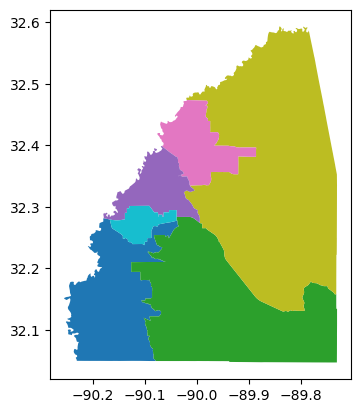

In [461]:
# to calculate assignment of blocks to districts, need to also include Pearl School District
# if not included, leads to a discrepancy in the total population of the blocks in Rankin School district here vs in Dave's Redistricting App
cd = gpd.overlay(current_districts, county.explode(), how='union')
cd.loc[cd.name.isna(), 'name'] = 'pearl'
cd=cd.iloc[[0,1,2,3,4,10],:].reset_index(drop=True) # diff geometry types create dupe rows
cd.plot(column='name')

In [462]:
a = maup.assign(blocks_2020, cd)
blocks_2020['current_district'] = a

/Users/kristenakey/.local/share/virtualenvs/rankin_school-board-tzA4L7yf/lib/python3.11/site-packages/maup/intersections.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/kristenakey/.local/share/virtualenvs/rankin_school-board-tzA4L7yf/lib/python3.11/site-packages/maup/intersections.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/kristenakey/.local/share/virtualenvs/rankin_school-board-tzA4L7yf/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a proje

In [463]:
# looks good! (5 = Pearl School District)
blocks_2020[blocks_2020['current_district']!=5]['P0010001'].sum()

135272

In [464]:
# Looks right!
blocks_2020[blocks_2020.current_district!=5]['total_minors_enrolled'].sum()

19518.266727539503

In [465]:
## Save block file
# blocks_2020.to_file('../ms_pl2020_b/ms_pl2020_p1_b-rankin_county.shp')

/var/folders/qc/7bpz4_qs0d1bhfr294bnmr_c0000gn/T/ipykernel_5066/3851030568.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  blocks_2020.to_file('../ms_pl2020_b/ms_pl2020_p1_b-rankin_county.shp')


*****************************************

In [574]:
# Current districts uploaded to Dave's Redistricting App. Exported 2020 block assignments to districts from DRA
# Check that my assignments match Dave's
dave_blocks_to_district = pd.read_csv('block-assignments.csv')

In [575]:
dave_blocks_to_district['GEOID20']=dave_blocks_to_district['GEOID20'].astype(str)
block_check = blocks_2020[['GEOID20', 'current_district', 'geometry']].merge(dave_blocks_to_district, on='GEOID20', how='left')

In [576]:
block_check['current_district'] = block_check['current_district']+1
block_check=block_check[block_check['current_district']!=6]
block_check['District'] = block_check['District'].str[-1:]

<Axes: >

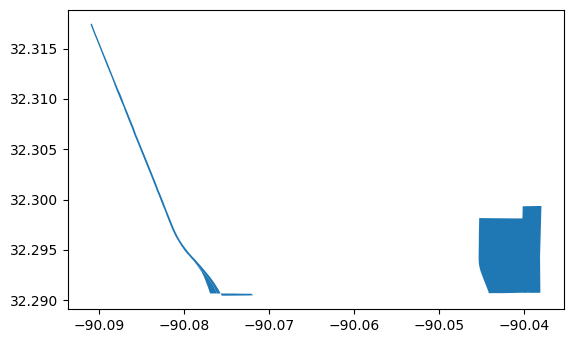

In [583]:
# these blocks go unassigned in DRA
block_check[block_check['District'].isna() ].plot()